In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/120dog breeds-224.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/projectDataset224')

In [ ]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization

In [ ]:
import pathlib
from keras.preprocessing.image import ImageDataGenerator


data_dir = pathlib.Path('/content/projectDataset224/120dog breeds-224')

data_train = data_dir / 'train'

test_dir = data_dir / 'test'


labels_csv = pd.read_csv('/content/drive/MyDrive/labels.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]

In [ ]:
batch_size = 16
img_size = 224

In [ ]:
# datagen = ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input, validation_split=0.2)
# train_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset='training',
#                         x_col='id',
#                         y_col='breed',
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode='sparse',
#                         color_mode='rgb',
#                         target_size=(img_size, img_size))

# validation_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset='validation',
#                         x_col='id', 
#                         y_col='breed',
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode='sparse',
#                         color_mode='rgb',
#                         target_size=(img_size, img_size))


train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# train_datagen = ImageDataGenerator(
#     preprocessing_function = keras.applications.inception_v3.preprocess_input, 
#     validation_split=0.2,
#     rotation_range=20, 
#     width_shift_range=0.2, 
#     height_shift_range=0.2, 
#     zoom_range=0.2, 
#     horizontal_flip=True, 
#     vertical_flip=True
# )


train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='training',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse',
    color_mode='rgb',
    target_size=(img_size, img_size)
)

validation_datagen = ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input, 
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='validation',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse',
    color_mode='rgb',
    target_size=(img_size, img_size)
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_curve, auc

# Define the ROC metrics
tpr = tf.keras.metrics.TruePositives(name='tp')
fpr = tf.keras.metrics.FalsePositives(name='fp')
auc_metric = AUC(name='auc')

In [ ]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))

for layer in resnet50.layers:
    layer.trainable=False

model = Sequential()
model.add(resnet50)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))
model.summary()

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              #loss='categorical_crossentropy',
              #loss='SparseSoftmaxCrossEntropyWithLogits',
              #loss='SparseSoftmaxCrossEntropyWithLogits',
              metrics=['accuracy'])
              # metrics=[tpr, fpr, auc_metric, 'accuracy', 'Precision', 'Recall', 'AUC'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 2048)       8192      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)             

In [ ]:
# history_res = model.fit(train_generator, epochs=50, verbose = 1,
#                        validation_data=validation_generator)

from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Resnet50-Epoch50DataAugmentationHigh.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)


history_res = model.fit(train_generator, epochs=50, verbose = 1,
                        validation_data=validation_generator,
                        callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
512/512 [==============================] - 141s 268ms/step - loss: 3.8390 - accuracy: 0.2070 - val_loss: 2.2657 - val_accuracy: 0.5905
Epoch 2/50
512/512 [==============================] - 133s 260ms/step - loss: 2.1792 - accuracy: 0.5172 - val_loss: 1.2816 - val_accuracy: 0.6893
Epoch 3/50
512/512 [==============================] - 132s 258ms/step - loss: 1.5401 - accuracy: 0.6175 - val_loss: 0.9982 - val_accuracy: 0.7177
Epoch 4/50
512/512 [==============================] - 133s 260ms/step - loss: 1.2781 - accuracy: 0.6620 - val_loss: 0.8761 - val_accuracy: 0.7407
Epoch 5/50
512/512 [==============================] - 132s 258ms/step - loss: 1.1299 - accuracy: 0.6854 - val_loss: 0.8230 - val_accuracy: 0.7436
Epoch 6/50
512/512 [==============================] - 132s 258ms/step - loss: 1.0391 - accuracy: 0.7079 - val_loss: 0.7834 - val_accuracy: 0.7549
Epoch 7/50
512/512 [==============================] - 132s 259ms/step - loss: 0.9614 - accuracy: 0.7255 - val_loss: 0.7648 -

In [ ]:
model.save('/content/drive/MyDrive/Resnet50-Epoch50DataAugmentationHighVersion2.h5')

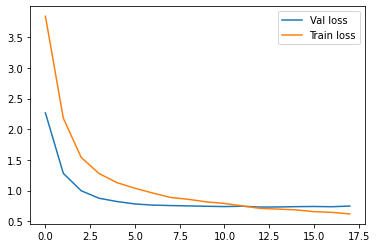

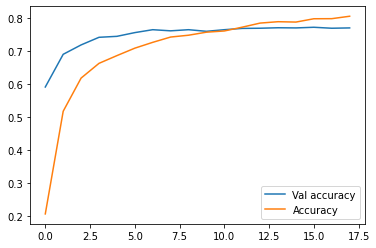

In [ ]:
plt.figure()
plt.plot(history_res .history['val_loss'], label = 'Val loss')
plt.plot(history_res .history['loss'], label = 'Train loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(history_res .history['val_accuracy'], label = 'Val accuracy')
plt.plot(history_res .history['accuracy'], label = 'Accuracy')
plt.legend()
plt.show()